In [230]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
import neurokit2 as nk
from scipy.optimize import least_squares
from scipy.signal import spectrogram
import copy

In [2]:
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)

In [50]:
T_c = 91.72 * (1e-6)   # Chirp time
SAMPLE_PER_CHIRP = 256
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
speed_of_light = 300000000
NUMBER_OF_CHANNEL=4
FPS=20 #20 frame/s
CHIRP_PER_FRAME=2 # 2 chirp/ frame
DURATION=5#minute
FRAME_COUNT = DURATION * 60 * FPS
SAMPLE_PER_FRAME = CHIRP_PER_FRAME *SAMPLE_PER_CHIRP
FFT_SIZE=2**10
RANGE_RESOLUTION =float(speed_of_light)/(2*B)
SAMPLING_RATE = 3000e3;
FREQ_SLOPE =40.8450012207031251e6*1e6
RANGE_BIN =(float(speed_of_light) * SAMPLING_RATE) / (2*FREQ_SLOPE*FFT_SIZE) ;

MAX_RANGE =(SAMPLING_RATE *speed_of_light)/(2*FREQ_SLOPE);

print("Number of frame: {0}".format(FRAME_COUNT))
print("Number of sample per frame: {0}".format(SAMPLE_PER_FRAME))
print("FFT size {0}".format(FFT_SIZE))
print("Range resolution {0}".format(RANGE_RESOLUTION))
print("Range bin {0}".format(RANGE_BIN))
print("Max range {0}".format(MAX_RANGE))

Number of frame: 6000
Number of sample per frame: 512
FFT size 1024
Range resolution 0.04
Range bin 0.010759043013010222
Max range 11.017260045322468


In [334]:
#read data
file_path = '../FMCW Radar/Rawdata/Rawdata_7.csv'
raw_data = readCsv(file_path)

In [335]:
RawData4Channel=np.array(raw_data).reshape(NUMBER_OF_CHANNEL,FRAME_COUNT,SAMPLE_PER_FRAME)

/var/folders/7_/v8dw7hn50j7dbqpv0scn2tv80000gn/T/ipykernel_17593/346900115.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(411)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


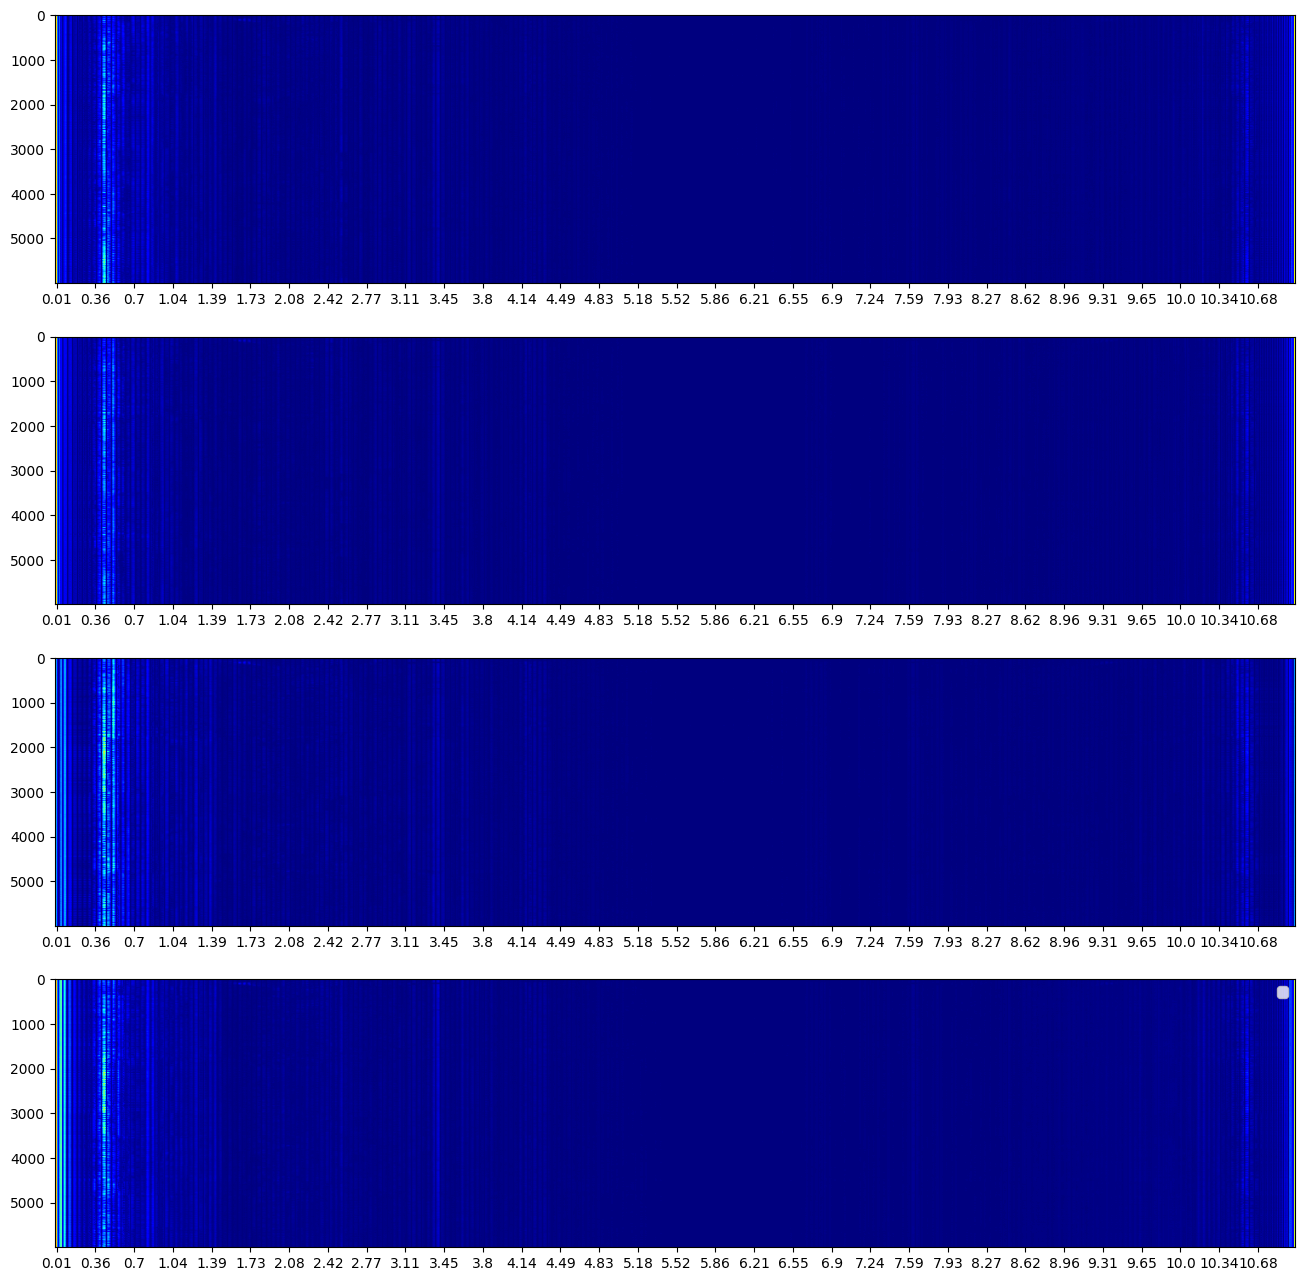

In [336]:
range_profile_matrixes =np.zeros((NUMBER_OF_CHANNEL,FRAME_COUNT,FFT_SIZE),dtype=complex)
for i in range(0,NUMBER_OF_CHANNEL):
    for j in range(0,FRAME_COUNT):
        range_profile_matrixes[i,j,:]=np.fft.fft(RawData4Channel[i,j,:],FFT_SIZE)
range_for_plotting =range(1,FFT_SIZE,2**5)
range_bin_distance =[round(j*RANGE_BIN,2) for j in range_for_plotting ]

plt.figure(figsize=(16,16))
plt.xlabel('Range')
plt.ylabel('Frame or time')
plt.title("Range time map")
plt.subplot(411)
plt.imshow(np.abs(range_profile_matrixes[0]),cmap='jet',aspect='auto')
plt.xticks(range_for_plotting, range_bin_distance)
plt.subplot(412)
plt.imshow(np.abs(range_profile_matrixes[1]),cmap='jet',aspect='auto')
plt.xticks(range_for_plotting, range_bin_distance)
plt.subplot(413)
plt.imshow(np.abs(range_profile_matrixes[2]),cmap='jet',aspect='auto')
plt.xticks(range_for_plotting, range_bin_distance)
plt.subplot(414)
plt.imshow(np.abs(range_profile_matrixes[3]),cmap='jet',aspect='auto')
plt.xticks(range_for_plotting, range_bin_distance)
plt.legend()
plt.show()


In [337]:
#MTI
alpha = 0.01
clutter_to_remove=np.zeros(((NUMBER_OF_CHANNEL,FRAME_COUNT,FFT_SIZE)),dtype=complex)
mti_output=np.zeros(((NUMBER_OF_CHANNEL,FRAME_COUNT,FFT_SIZE//2)),dtype=complex)
for ii in range(0,NUMBER_OF_CHANNEL):
    for jj in range(1,FRAME_COUNT):
        clutter_to_remove[ii,jj,:] =alpha * range_profile_matrixes[ii,jj,:] +(1-alpha)*clutter_to_remove[ii,jj-1,:]
        mti_output[ii,jj,:] =range_profile_matrixes[ii,jj,0:FFT_SIZE//2] -clutter_to_remove[ii,jj,0:FFT_SIZE//2]


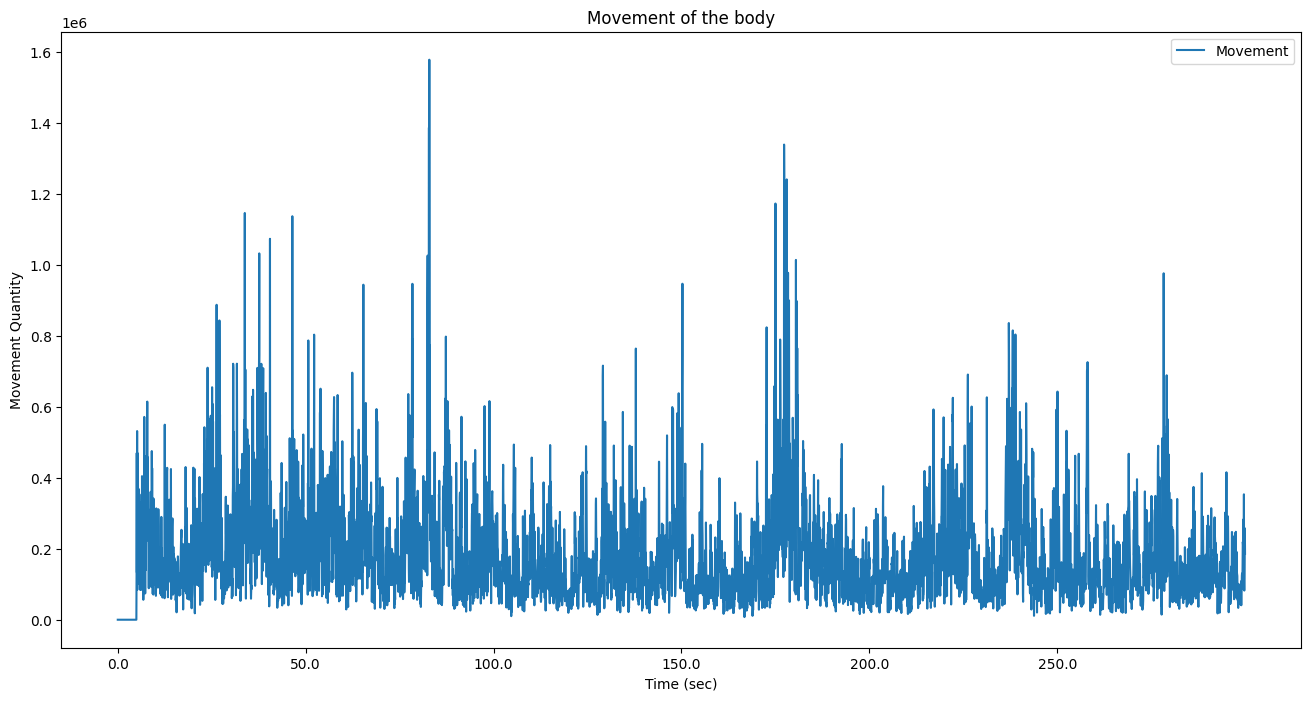

In [338]:
MTI_Sum_Rx_0= np.sum(np.abs(mti_output[0,:,:]),axis=1)
Movement_Rx_0 =np.abs(MTI_Sum_Rx_0[1:] - MTI_Sum_Rx_0[0:-1])
Movement_Rx_0=np.append(MTI_Sum_Rx_0[0],Movement_Rx_0)


MTI_Sum_Rx_1= np.sum(np.abs(mti_output[1,:,:]),axis=1)
Movement_Rx_1 =np.abs(MTI_Sum_Rx_1[1:] - MTI_Sum_Rx_1[0:-1])
Movement_Rx_1=np.append(MTI_Sum_Rx_1[0],Movement_Rx_1)


MTI_Sum_Rx_2= np.sum(np.abs(mti_output[2,:,:]),axis=1)
Movement_Rx_2 =np.abs(MTI_Sum_Rx_2[1:] - MTI_Sum_Rx_2[0:-1])
Movement_Rx_2=np.append(MTI_Sum_Rx_2[0],Movement_Rx_2)


MTI_Sum_Rx_3= np.sum(np.abs(mti_output[3,:,:]),axis=1)
Movement_Rx_3 =np.abs(MTI_Sum_Rx_3[1:] - MTI_Sum_Rx_3[0:-1])
Movement_Rx_3=np.append(MTI_Sum_Rx_3[0],Movement_Rx_3)

Total_Movement_Sum = Movement_Rx_0 + Movement_Rx_1 + Movement_Rx_2 + Movement_Rx_3 ;
Total_Movement_Sum[:100] = 0;
Total_MovementFlag = Total_Movement_Sum >= 850000;

plotting_range =range(0,len(Total_Movement_Sum),FPS*50)
xticks= [ xplt/FPS for xplt in plotting_range]

plt.figure(figsize=(16,8))
plt.title("Movement of the body")
plt.xlabel('Time (sec)');
plt.ylabel('Movement Quantity');
plt.plot(Total_Movement_Sum,label="Movement")
plt.xticks(plotting_range,xticks)
plt.legend()
plt.show()

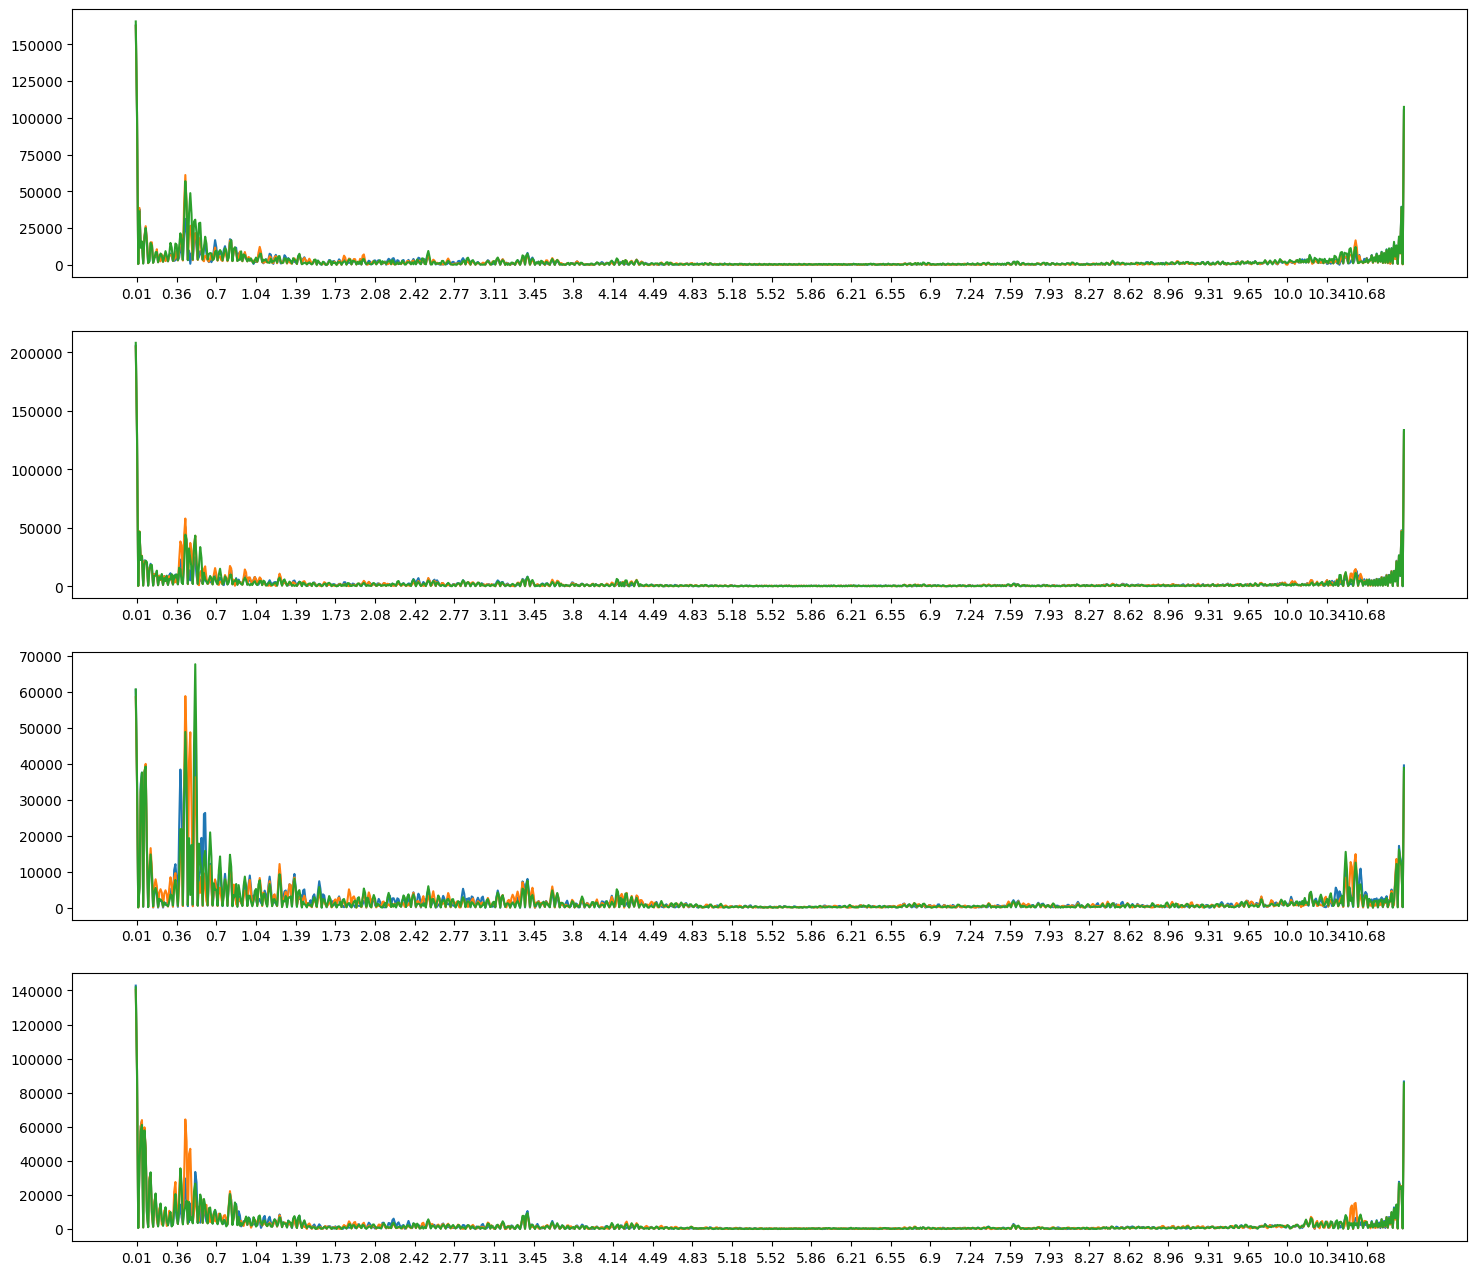

In [339]:
magnitude_of_channel =np.array([np.abs(range_profile_matrixes[channel_index]) for channel_index in range(0,4)])
plt.figure(figsize=(18,16))
plt.subplot(411)
plt.plot(magnitude_of_channel[0][0])
plt.plot(magnitude_of_channel[0][-1])
plt.plot(magnitude_of_channel[0][1024])
plt.xticks(range_for_plotting, range_bin_distance)

plt.subplot(412)
plt.plot(magnitude_of_channel[1][0])
plt.plot(magnitude_of_channel[1][-1])
plt.plot(magnitude_of_channel[1][1024])
plt.xticks(range_for_plotting, range_bin_distance)

plt.subplot(413)
plt.plot(magnitude_of_channel[2][0])
plt.plot(magnitude_of_channel[2][-1])
plt.plot(magnitude_of_channel[2][1024])
plt.xticks(range_for_plotting, range_bin_distance)

plt.subplot(414)
plt.plot(magnitude_of_channel[3][0])
plt.plot(magnitude_of_channel[3][-1])
plt.plot(magnitude_of_channel[3][1024])
plt.xticks(range_for_plotting, range_bin_distance)
plt.show()

In [340]:
magnitude_of_channel =np.abs(range_profile_matrixes[0])
max_indices =np.array([0]*len(magnitude_of_channel))
for mag_profile in magnitude_of_channel:
    max_index = np.argmax(mag_profile[10:-1])+10
    max_indices[max_index]+=1
interesting_bin =np.argmax(max_indices)
print("Target at bin :{0}th, distance: {1}m".format(interesting_bin,interesting_bin* RANGE_BIN))

Target at bin :40th, distance: 0.4303617205204089m


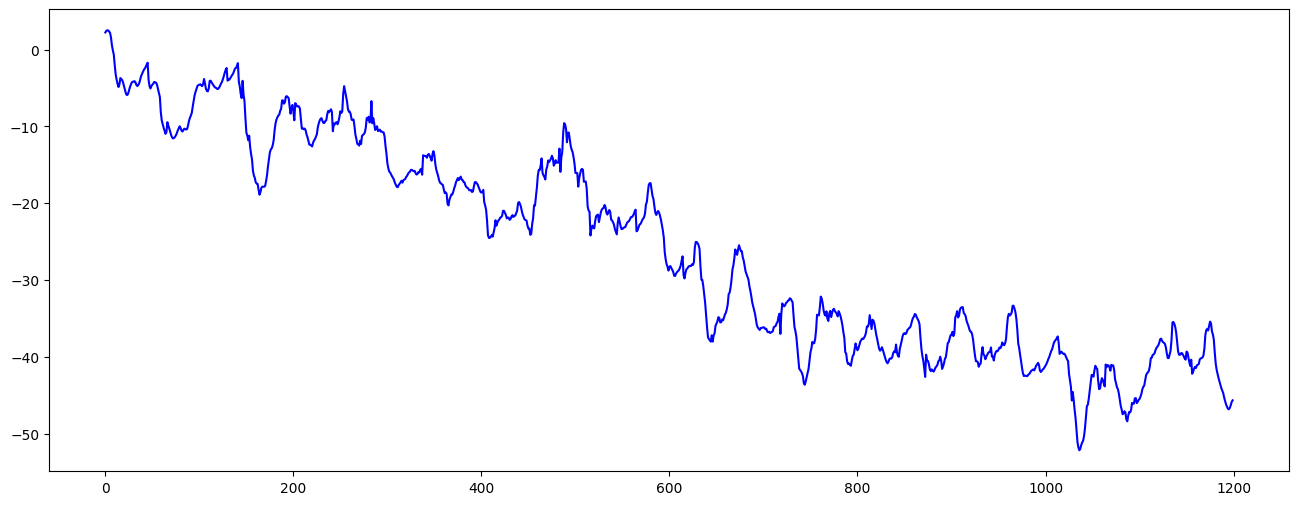

In [341]:
selected_phase = range_profile_matrixes[0][:,interesting_bin]
phase_angle =np.angle(selected_phase)
phase_angle_unwrapped = np.unwrap(phase_angle)
plt.figure(figsize=(16,6))
plt.plot(phase_angle_unwrapped[:1200],color="blue")
plt.show()

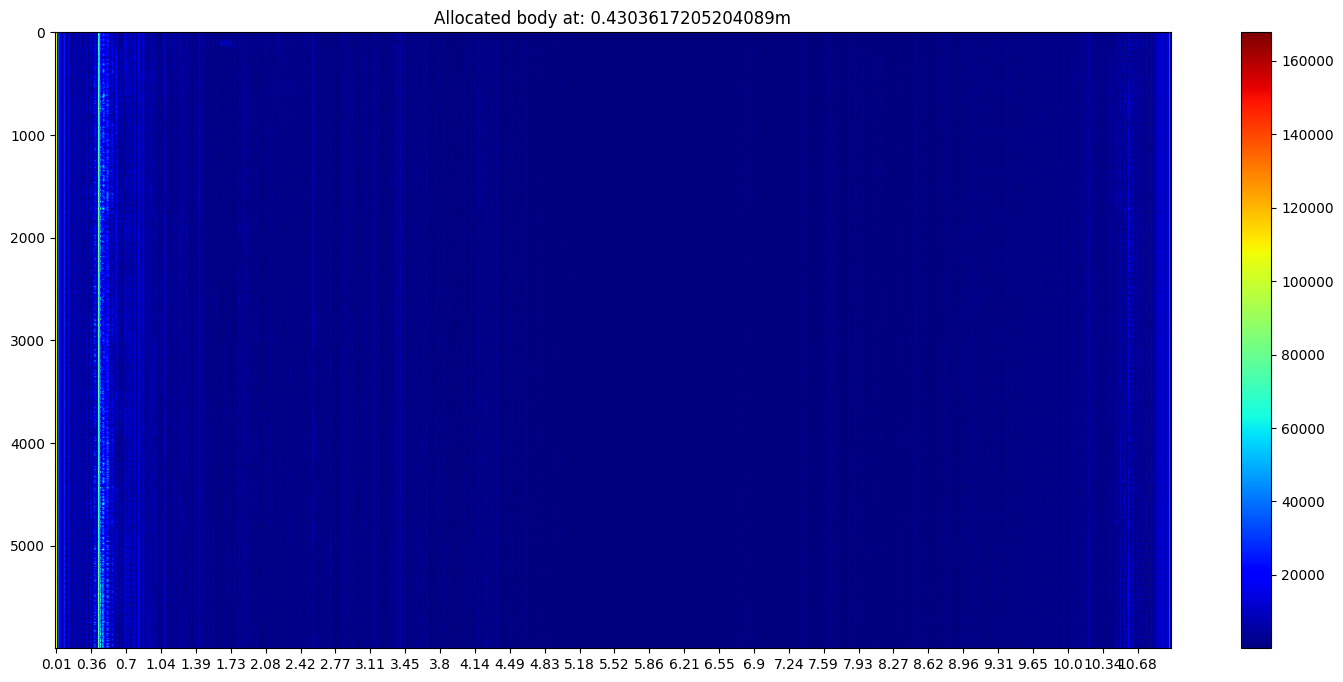

In [342]:
distance = RANGE_BIN*interesting_bin 
tmp_magnitude= copy.deepcopy(np.abs(range_profile_matrixes[0]))
for tmp_index,tmp_mag in enumerate(tmp_magnitude):
    tmp_mag[interesting_bin]= 160000

plt.figure(figsize=(18,8))
plt.imshow(tmp_magnitude,cmap='jet',aspect='auto')
plt.title("Allocated body at: {0}m".format(distance))
plt.xticks(range_for_plotting, range_bin_distance)
plt.colorbar()
plt.show()


In [343]:
def filter_signal (signal_to_filter ,_low_freq,_high_freq,_sampling_rate,_filter_order):
    sampling_rate = _sampling_rate# Sampling rate of the input signal
    low_freq = _low_freq  # Lower cutoff frequency of the bandpass filter
    high_freq = _high_freq  # Upper cutoff frequency of the bandpass filter
    filter_order = _filter_order # Order of the bandpass filter

    # Compute the normalized cutoff frequencies
    nyquist_freq = 0.5 * sampling_rate
    low_norm = low_freq / nyquist_freq
    high_norm = high_freq / nyquist_freq
    
    # Design the bandpass filter
    b, a = butter(filter_order, [low_norm, high_norm], btype='band')

    # Apply the bandpass filter to the input signal
    signal_filtered = filtfilt(b, a, signal_to_filter)
    return signal_filtered

In [344]:
EXTRACTED_SAMPLING_RATE =6000/300

breath_band_filtering=[20/60,60/60]
breath_filtered_signal =filter_signal(np.array(phase_angle_unwrapped),breath_band_filtering[0],breath_band_filtering[1],EXTRACTED_SAMPLING_RATE,4)

heart_band_filtering=[80/60,120/60]
heart_filtered_signal =filter_signal(np.array(phase_angle_unwrapped),heart_band_filtering[0],heart_band_filtering[1],EXTRACTED_SAMPLING_RATE,4)

/var/folders/7_/v8dw7hn50j7dbqpv0scn2tv80000gn/T/ipykernel_17593/2129146938.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(211)


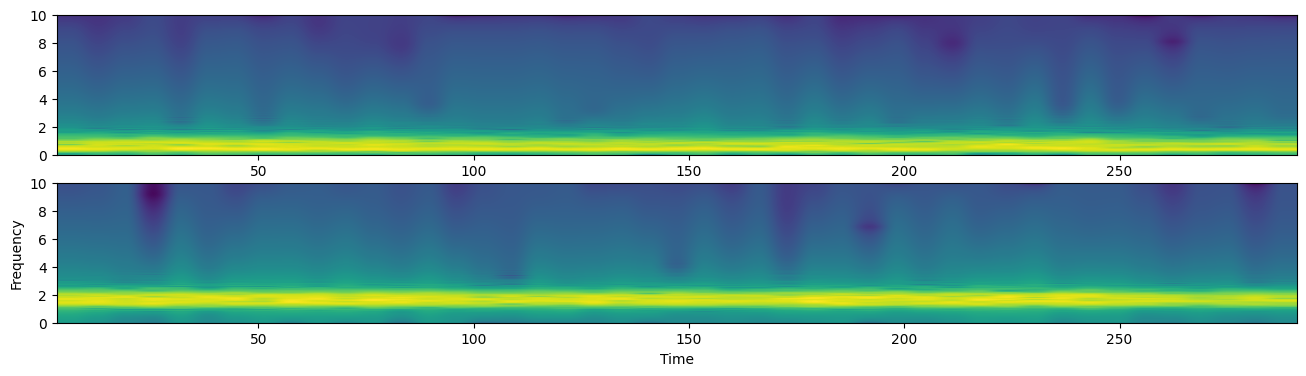

In [345]:
plt.figure(figsize=(16,4))
plt.title("Phase unwrapped spectrogram in 1 minute at bin{0}".format(interesting_bin))
plt.subplot(211)
plt.specgram(breath_filtered_signal,Fs=EXTRACTED_SAMPLING_RATE)
plt.subplot(212)
plt.specgram(heart_filtered_signal,Fs=EXTRACTED_SAMPLING_RATE)

plt.xlabel("Time")
plt.ylabel("Frequency")

plt.show()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


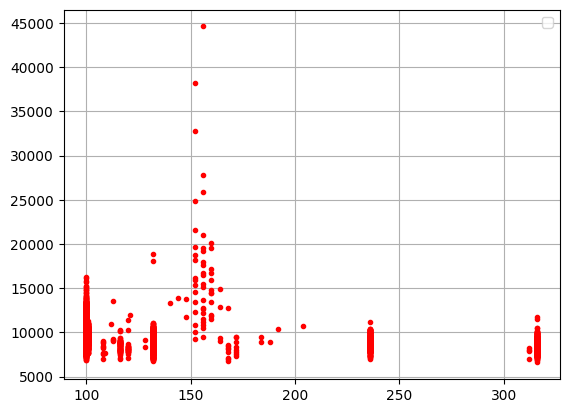

(6000,)
(6000,)
Index: 100 Value: 3286
Index: 132 Value: 849
Index: 316 Value: 796
Index: 236 Value: 467
Index: 101 Value: 404
Index: 116 Value: 73
Index: 120 Value: 24
Index: 156 Value: 21
Index: 152 Value: 16
Index: 160 Value: 12
Index: 108 Value: 9
Index: 168 Value: 9
Index: 172 Value: 8
Index: 113 Value: 4
Index: 164 Value: 4
Index: 312 Value: 4
Index: 128 Value: 2
Index: 148 Value: 2
Index: 184 Value: 2
Index: 109 Value: 1
Index: 112 Value: 1
Index: 121 Value: 1
Index: 140 Value: 1
Index: 144 Value: 1
Index: 188 Value: 1
Index: 192 Value: 1
Index: 204 Value: 1
Index: 0 Value: 0
Index: 1 Value: 0
Index: 2 Value: 0
Index: 3 Value: 0
Index: 4 Value: 0
Index: 5 Value: 0
Index: 6 Value: 0
Index: 7 Value: 0
Index: 8 Value: 0
Index: 9 Value: 0
Index: 10 Value: 0
Index: 11 Value: 0
Index: 12 Value: 0
Index: 13 Value: 0
Index: 14 Value: 0
Index: 15 Value: 0
Index: 16 Value: 0
Index: 17 Value: 0
Index: 18 Value: 0
Index: 19 Value: 0
Index: 20 Value: 0
Index: 21 Value: 0
Index: 22 Value: 0
I

In [346]:
#calculate variance for each channel
#channel 0
magnitude_of_channel_0 =np.abs(range_profile_matrixes[0])
index_of_max_variance =np.array([-1]*len(range_profile_matrixes[0]))
mag_max_var=np.array([-1]*len(range_profile_matrixes[0]))
for mIndex,mag in enumerate(magnitude_of_channel_0):
    mean =  np.mean(mag)
    array_of_mean=np.array([mean]* len(mag))
    max_diff =np.argmax(np.abs(array_of_mean[100:-100]- mag[100:-100]))+100
    
    index_of_max_variance[mIndex] =max_diff
    mag_max_var[mIndex]=mag[max_diff]
    

plt.plot(index_of_max_variance,mag_max_var,color='red', marker='o',linestyle='None', markersize=3)
plt.legend()
plt.grid(True)
plt.show()

print(index_of_max_variance.shape)
occurrent=np.array([0]*index_of_max_variance.shape[0] )
print(occurrent.shape)
for imax in index_of_max_variance:
    occurrent[imax]+=1

sorted_with_index = sorted(enumerate(occurrent), key=lambda x: x[1],reverse=True)

# Print the sorted array with indices
for index, value in sorted_with_index:
    print("Index:", index, "Value:", value)
argmax =np.argmax(occurrent)
print(argmax)



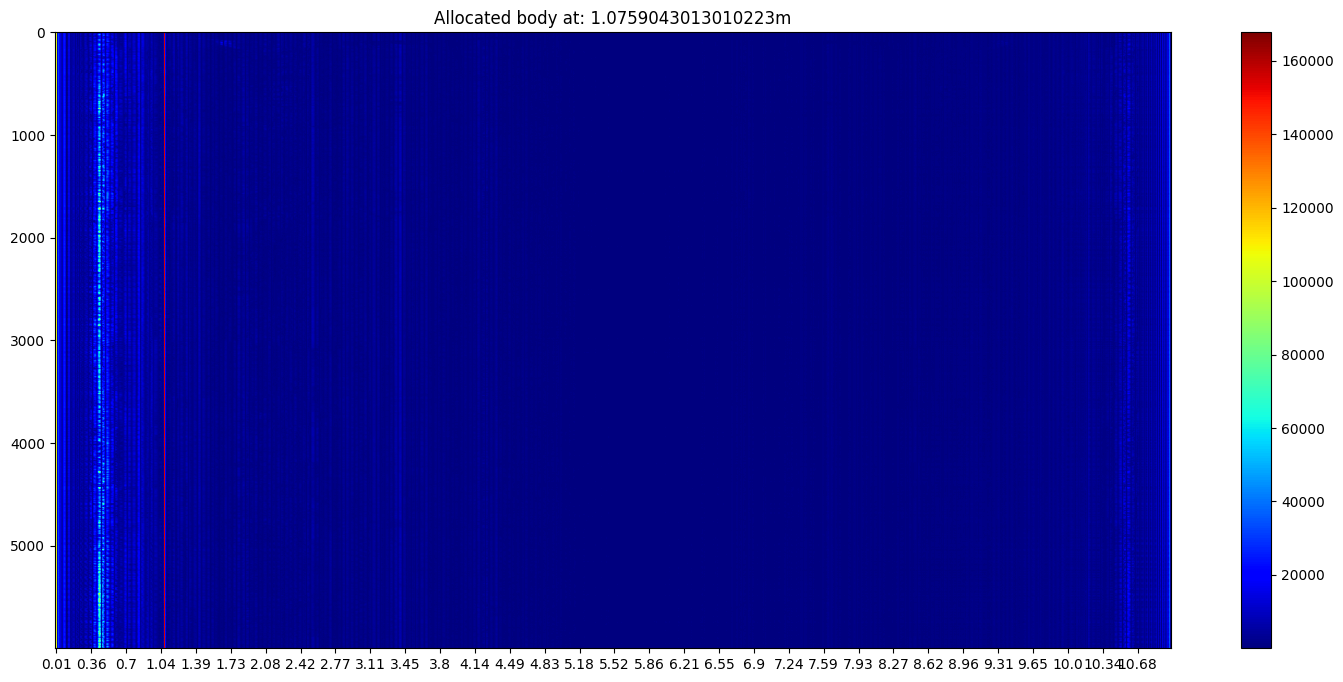

6255.412732500357


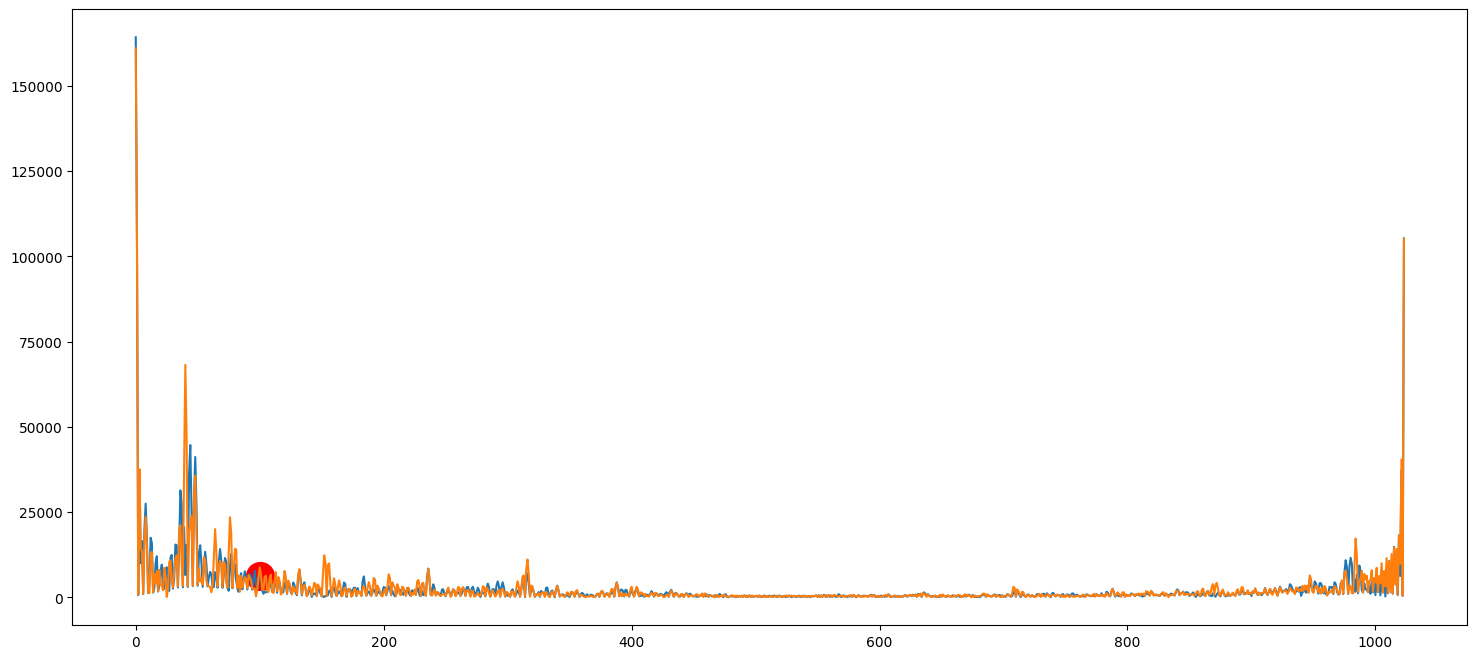

In [347]:
distance = RANGE_BIN*argmax 
tmp_magnitude= copy.deepcopy(magnitude_of_channel_0)
for tmp_index,tmp_mag in enumerate(tmp_magnitude):
    tmp_mag[argmax]= 160000

plt.figure(figsize=(18,8))
plt.imshow(tmp_magnitude,cmap='jet',aspect='auto')
plt.title("Allocated body at: {0}m".format(distance))
plt.xticks(range_for_plotting, range_bin_distance)
plt.colorbar()
plt.show()

print(magnitude_of_channel_0[3000][argmax])
plt.figure(figsize=(18,8))
plt.plot(argmax,magnitude_of_channel_0[3000][argmax],color='red', marker='o',linestyle='None', markersize=20)
plt.plot(magnitude_of_channel_0[3000])
plt.plot(magnitude_of_channel_0[125])
plt.show()

In [348]:
def filter_signal (signal_to_filter ,_low_freq,_high_freq,_sampling_rate,_filter_order):
    sampling_rate = _sampling_rate# Sampling rate of the input signal
    low_freq = _low_freq  # Lower cutoff frequency of the bandpass filter
    high_freq = _high_freq  # Upper cutoff frequency of the bandpass filter
    filter_order = _filter_order # Order of the bandpass filter

    # Compute the normalized cutoff frequencies
    nyquist_freq = 0.5 * sampling_rate
    low_norm = low_freq / nyquist_freq
    high_norm = high_freq / nyquist_freq
    
    # Design the bandpass filter
    b, a = butter(filter_order, [low_norm, high_norm], btype='band')

    # Apply the bandpass filter to the input signal
    signal_filtered = filtfilt(b, a, signal_to_filter)
    return signal_filtered

In [349]:
breath_heart_band_filtering=[20/60,120/60]
filtered_signal =filter_signal(np.array(phase_angle_unwrapped),breath_heart_band_filtering[0],breath_heart_band_filtering[1],EXTRACTED_SAMPLING_RATE,4)

breath_band_filtering=[20/60,60/60]
breath_filtered_signal =filter_signal(np.array(phase_angle_unwrapped),breath_band_filtering[0],breath_band_filtering[1],EXTRACTED_SAMPLING_RATE,4)

heart_band_filtering=[80/60,120/60]
heart_filtered_signal =filter_signal(np.array(phase_angle_unwrapped),heart_band_filtering[0],heart_band_filtering[1],EXTRACTED_SAMPLING_RATE,4)